In [1]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
import seaborn as sns
from rembg import remove


In [2]:
def resize_image(image, target_size):
    height, width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * width / target_width)
            original_y = int(i * height / target_height)
            resized_image[i, j] = image[original_y, original_x]

    return resized_image

In [3]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = []
    path = []
    data_distribution = {}
    datakategori = {}

    for label in os.listdir(folder):
        folder_path = os.path.join(folder, label)
        images = os.listdir(folder_path)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(f"Loading kategori: {label}")
        
        kategori_data = []

        for filename in tqdm(images):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (250, 250))
                filenames.append(filename)
                path.append(label)
                data.append(img)
                kategori_data.append((filename, img))

        datakategori[label] = kategori_data

    return data, filenames, datalabel, path, data_distribution, datakategori

In [4]:

data, filenames, label, path, distribusi, datakategori = insertGambar("datasetfix/")
print("Total Data:", len(data))
print("Label unik:", label)
print("Distribusi data:", distribusi)


Loading kategori: Cyttaria_espinosae


100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Loading kategori: Morchella_esculenta


100%|██████████| 100/100 [00:14<00:00,  7.03it/s]

Total Data: 200
Label unik: ['Cyttaria_espinosae', 'Morchella_esculenta']
Distribusi data: {'Cyttaria_espinosae': 100, 'Morchella_esculenta': 100}


In [5]:
def display_sample(datakategori):
    for kategori, data in datakategori.items():
        print(f"Menampilkan sample untuk kategori: {kategori}")
        images = [img for _, img in data]
        plt.figure(figsize=(20, 3))
        for i in range(min(7, len(images))):
            plt.subplot(1, 7, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if len(images[i].shape) == 2:  # grayscale
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
        plt.suptitle(f"Kategori: {kategori}")
        plt.show()

Menampilkan sample untuk kategori: Cyttaria_espinosae


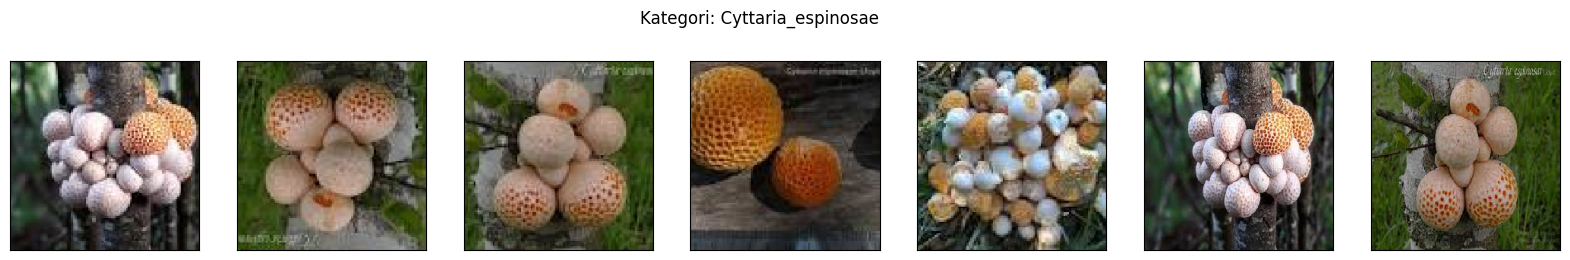

Menampilkan sample untuk kategori: Morchella_esculenta


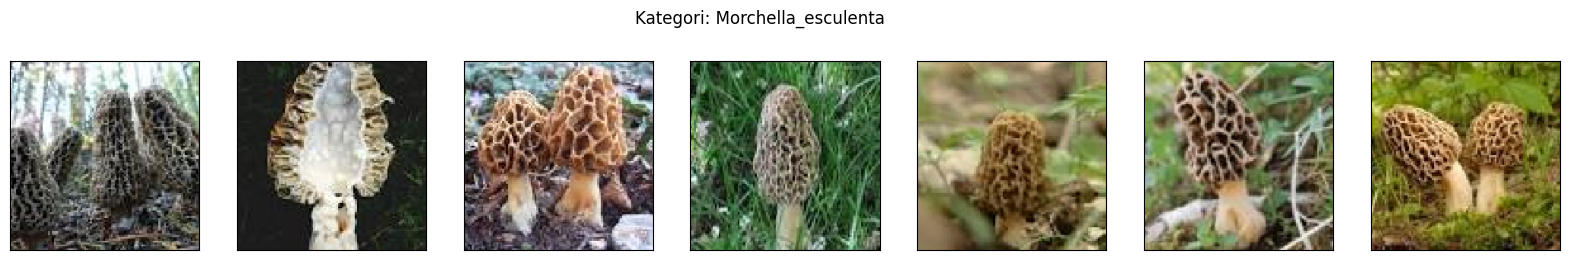

In [6]:
display_sample(datakategori)

In [7]:
def removeBackgroundByCategory(data):
    removed_data = {}

    for kategori, items in data.items():
        removed_list = []
        for filename, img in tqdm(items, desc=f"remove background {kategori}"):
            img_removed = remove(img) 
            removed_list.append((filename, img_removed))
        removed_data[kategori] = removed_list

    return removed_data


In [8]:
removej = removeBackgroundByCategory(datakategori) 

def gray_scaling(data):
    gray_data = {}

    for kategori, items in data.items():
        gray_list = []
        for filename, img in tqdm(items, desc=f"grayscaling {kategori}"):
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            gray_list.append((filename, gray))  
        gray_data[kategori] = gray_list

    return gray_data

grayj = gray_scaling(removej)


grayscaling Morchella_esculenta: 100%|██████████| 100/100 [00:00<00:00, 10259.29it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


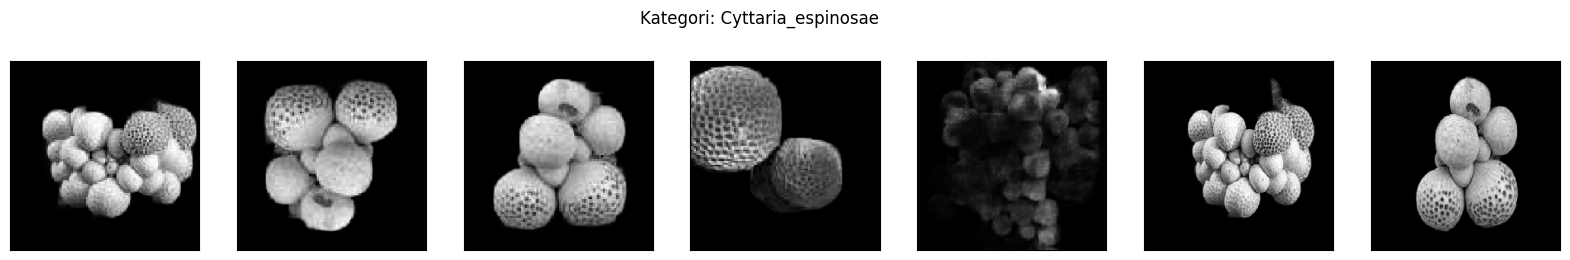

Menampilkan sample untuk kategori: Morchella_esculenta


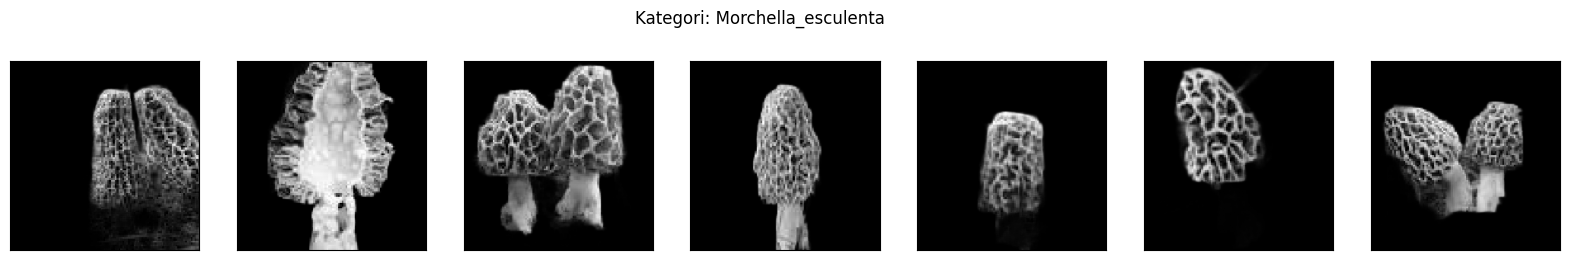

In [9]:
display_sample(grayj)

gray_images = []

for kategori in grayj:
    for filename, img in grayj[kategori]:
        gray_images.append(img)

Median Cyttaria_espinosae:   0%|          | 0/100 [00:00<?, ?it/s]

Median Morchella_esculenta: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


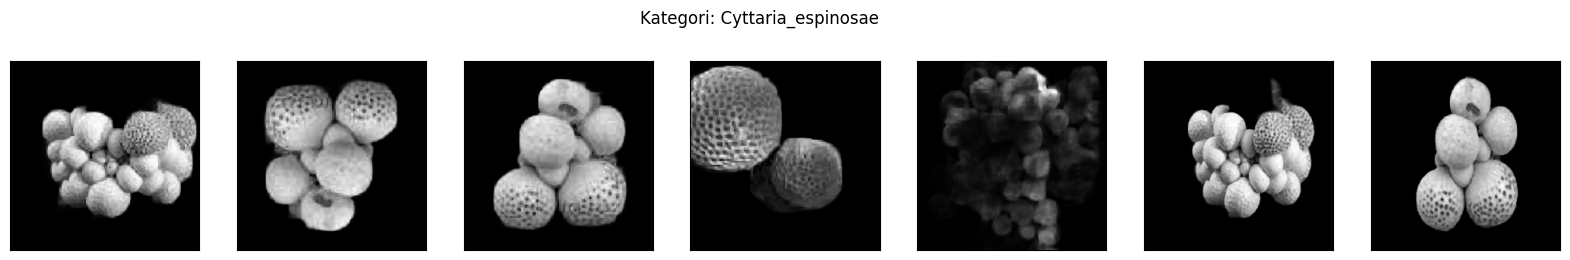

Menampilkan sample untuk kategori: Morchella_esculenta


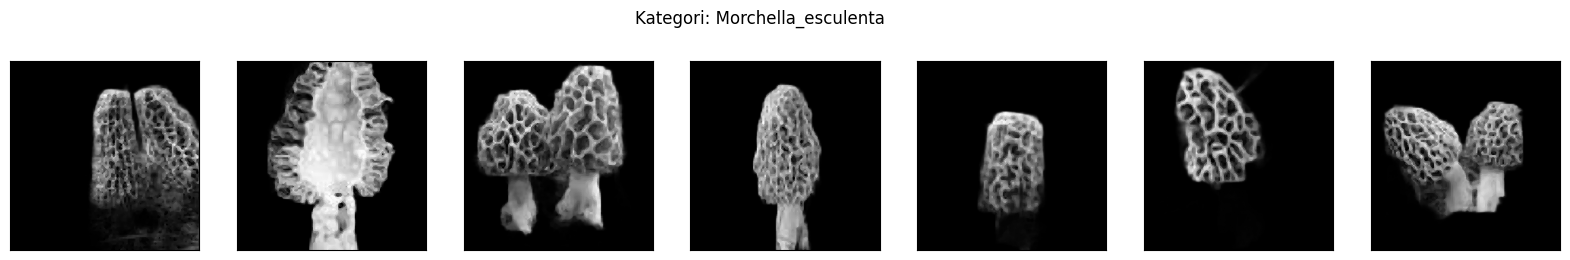

In [10]:
def median(image, ksize=3):
    assert ksize % 2 == 1
    pad = ksize // 2
    padded_img = np.pad(image, pad, mode='edge')
    h, w = image.shape
    filtered_img = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            window = []
            for m in range(-pad, pad + 1):
                for n in range(-pad, pad + 1):
                    val = padded_img[i + pad + m, j + pad + n]
                    window.append(int(val))

            window.sort()
            median_val = window[len(window) // 2]
            filtered_img[i, j] = median_val

    return filtered_img

def apply_manual_median_filter(data, ksize=3):
    filtered_data = {}

    for kategori, items in data.items():
        filtered_list = []
        for filename, img in tqdm(items, desc=f"Median {kategori}"):
            filtered_img = median(img, ksize)
            filtered_list.append((filename, filtered_img))
        filtered_data[kategori] = filtered_list

    return filtered_data

medianimg = apply_manual_median_filter(grayj)
display_sample(medianimg)

gray_images = []

for kategori in medianimg:
    for filename, img in medianimg[kategori]:
        gray_images.append(img)


Sharpening Cyttaria_espinosae:   0%|          | 0/100 [00:00<?, ?it/s]

Sharpening Morchella_esculenta: 100%|██████████| 100/100 [00:00<00:00, 5280.90it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


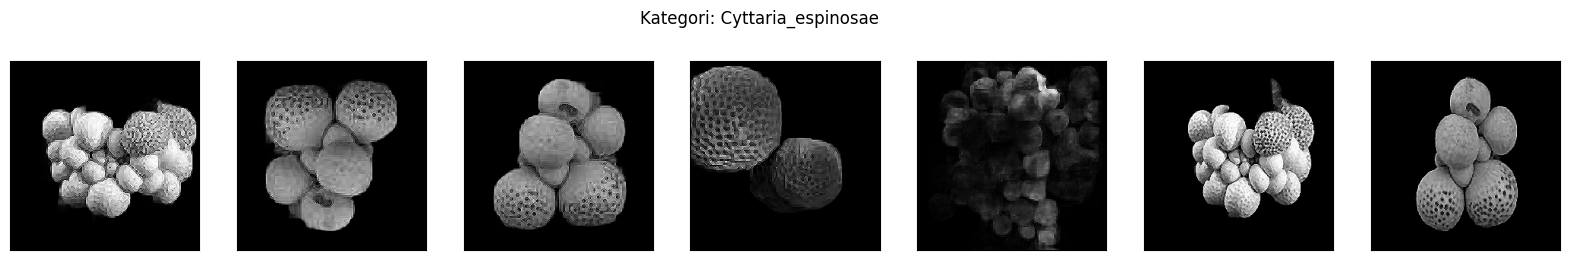

Menampilkan sample untuk kategori: Morchella_esculenta


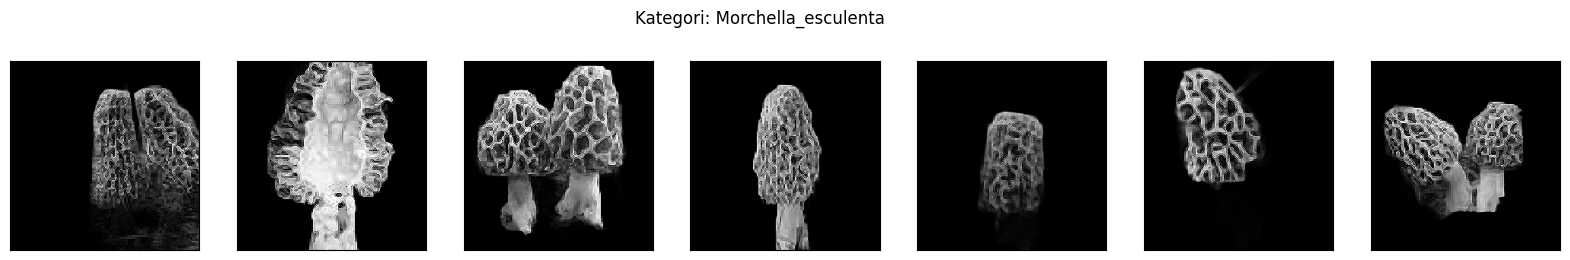

In [11]:
def sharpening_filter(img):
    # Kernel sharpening sederhana
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    
    # Terapkan kernel dengan filter2D dari OpenCV
    sharpened = cv.filter2D(img, -1, kernel)
    return sharpened
def apply_sharpening_filter(data_dict):
    sharpened_data = {}
    for kategori, items in data_dict.items():
        sharpened_list = []
        for filename, img in tqdm(items, desc=f"Sharpening {kategori}"):
            sharpened_img = sharpening_filter(img)
            sharpened_list.append((filename, sharpened_img))
        sharpened_data[kategori] = sharpened_list
    return sharpened_data

sharpened_result = apply_sharpening_filter(medianimg)  # atau medianimg, atau graypcos
display_sample(sharpened_result)

gray_images = []
for kategori in sharpened_result:
    for filename, img in sharpened_result[kategori]:
        gray_images.append(img)


treshold filter Morchella_esculenta: 100%|██████████| 100/100 [00:04<00:00, 23.94it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


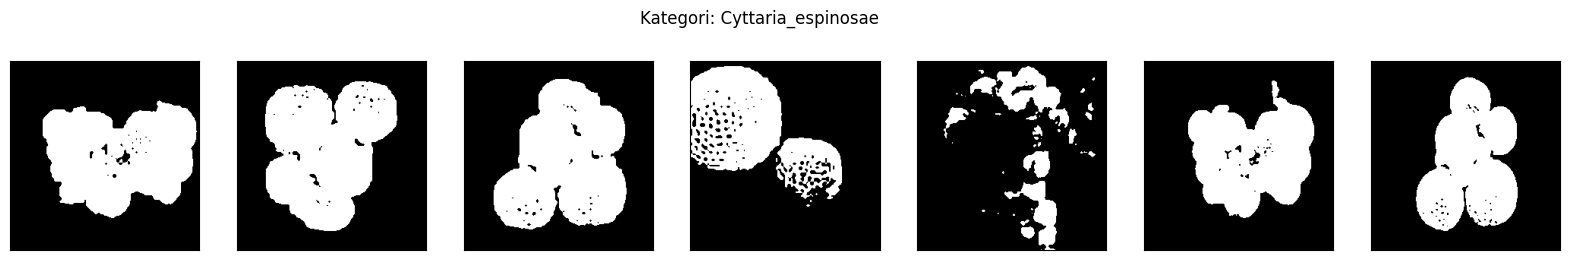

Menampilkan sample untuk kategori: Morchella_esculenta


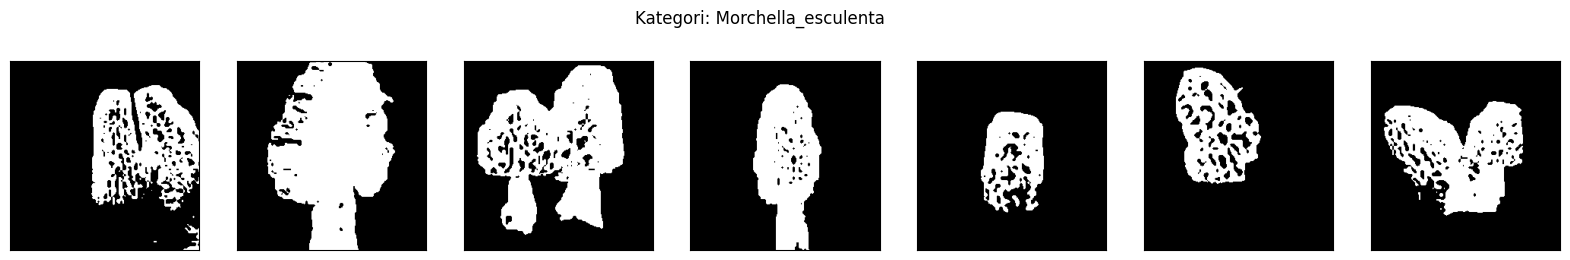

In [12]:
def threshold(image):
    thresh_value = 45
    max_value = 1

    height, width = image.shape
    result = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            if image[i, j] > thresh_value:
                result[i, j] = max_value
            else:
                result[i, j] = 0
    return  result

def thresholdFilterData(data):
    hasil = {}
    for kategori, data in data.items():
        tresh_list = []
        for filename, img in tqdm(data, desc=f"treshold filter {kategori}"):
            tres = threshold(img)
            tresh_list.append((filename, tres))
        hasil[kategori] = tresh_list
    return hasil

thresholded_images = thresholdFilterData(medianimg)

display_sample(thresholded_images)

# Jika mau ambil jadi list biasa
gray_images = []
for kategori in thresholded_images:
    for filename, img in thresholded_images[kategori]:
        gray_images.append(img)


In [13]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [14]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [15]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [16]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [17]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [18]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [19]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [20]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [21]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(gray_images)):
    D0 = glcm(gray_images[i], 0)
    D45 = glcm(gray_images[i], 45)
    D90 = glcm(gray_images[i], 90)
    D135 = glcm(gray_images[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [22]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [23]:
for i in range(len(gray_images)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [24]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [25]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [26]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [27]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [28]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [29]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [30]:
label = [1] * 100 + [0] * 100
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,asli_Cyttaria_espinosae0.png,Cyttaria_espinosae,0.009896,0.013935,0.009382,0.013742,0.995052,0.993032,0.995309,0.993129,...,0.531975,0.526898,0.729021,0.725747,0.729366,0.725877,0.978428,0.969676,0.979549,0.970097
1,asli_Cyttaria_espinosae1 - 180.png,Cyttaria_espinosae,0.011695,0.015838,0.010506,0.016064,0.994153,0.992081,0.994747,0.991968,...,0.513928,0.507832,0.716077,0.712777,0.716888,0.712623,0.975414,0.966751,0.977913,0.966277
2,asli_Cyttaria_espinosae1.png,Cyttaria_espinosae,0.011952,0.015838,0.010378,0.015838,0.994024,0.992081,0.994811,0.992081,...,0.514682,0.508672,0.716340,0.713212,0.717413,0.713212,0.974841,0.966708,0.978155,0.966708
3,asli_Cyttaria_espinosae10.png,Cyttaria_espinosae,0.023036,0.031709,0.023904,0.033580,0.988482,0.984145,0.988048,0.983210,...,0.570675,0.561101,0.756328,0.750233,0.755430,0.749066,0.943186,0.921984,0.941123,0.917381
4,asli_Cyttaria_espinosae11.png,Cyttaria_espinosae,0.018570,0.026661,0.018297,0.025822,0.990715,0.986670,0.990851,0.987089,...,0.746807,0.738819,0.863927,0.859084,0.864180,0.859546,0.921114,0.887042,0.922216,0.890596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,rotasi90_Morchella_esculenta2.png,Morchella_esculenta,0.015968,0.026032,0.018506,0.022645,0.992016,0.986984,0.990747,0.988678,...,0.679180,0.674274,0.825609,0.819178,0.824124,0.821142,0.947241,0.914254,0.938855,0.925411
196,rotasi90_Morchella_esculenta20.png,Morchella_esculenta,0.016546,0.028064,0.020819,0.025129,0.991727,0.985968,0.989590,0.987436,...,0.751030,0.746140,0.868990,0.862184,0.866620,0.863794,0.927614,0.877643,0.908921,0.890441
197,rotasi90_Morchella_esculenta23.png,Morchella_esculenta,0.038394,0.058612,0.045880,0.059805,0.980803,0.970694,0.977060,0.970097,...,0.492021,0.479230,0.706629,0.693024,0.701442,0.692264,0.917212,0.873828,0.901165,0.871259
198,rotasi90_Morchella_esculenta38.png,Morchella_esculenta,0.013365,0.026742,0.022008,0.023516,0.993317,0.986629,0.988996,0.988242,...,0.800562,0.798487,0.899388,0.891865,0.894741,0.893581,0.924877,0.850230,0.876300,0.868296


<Axes: >

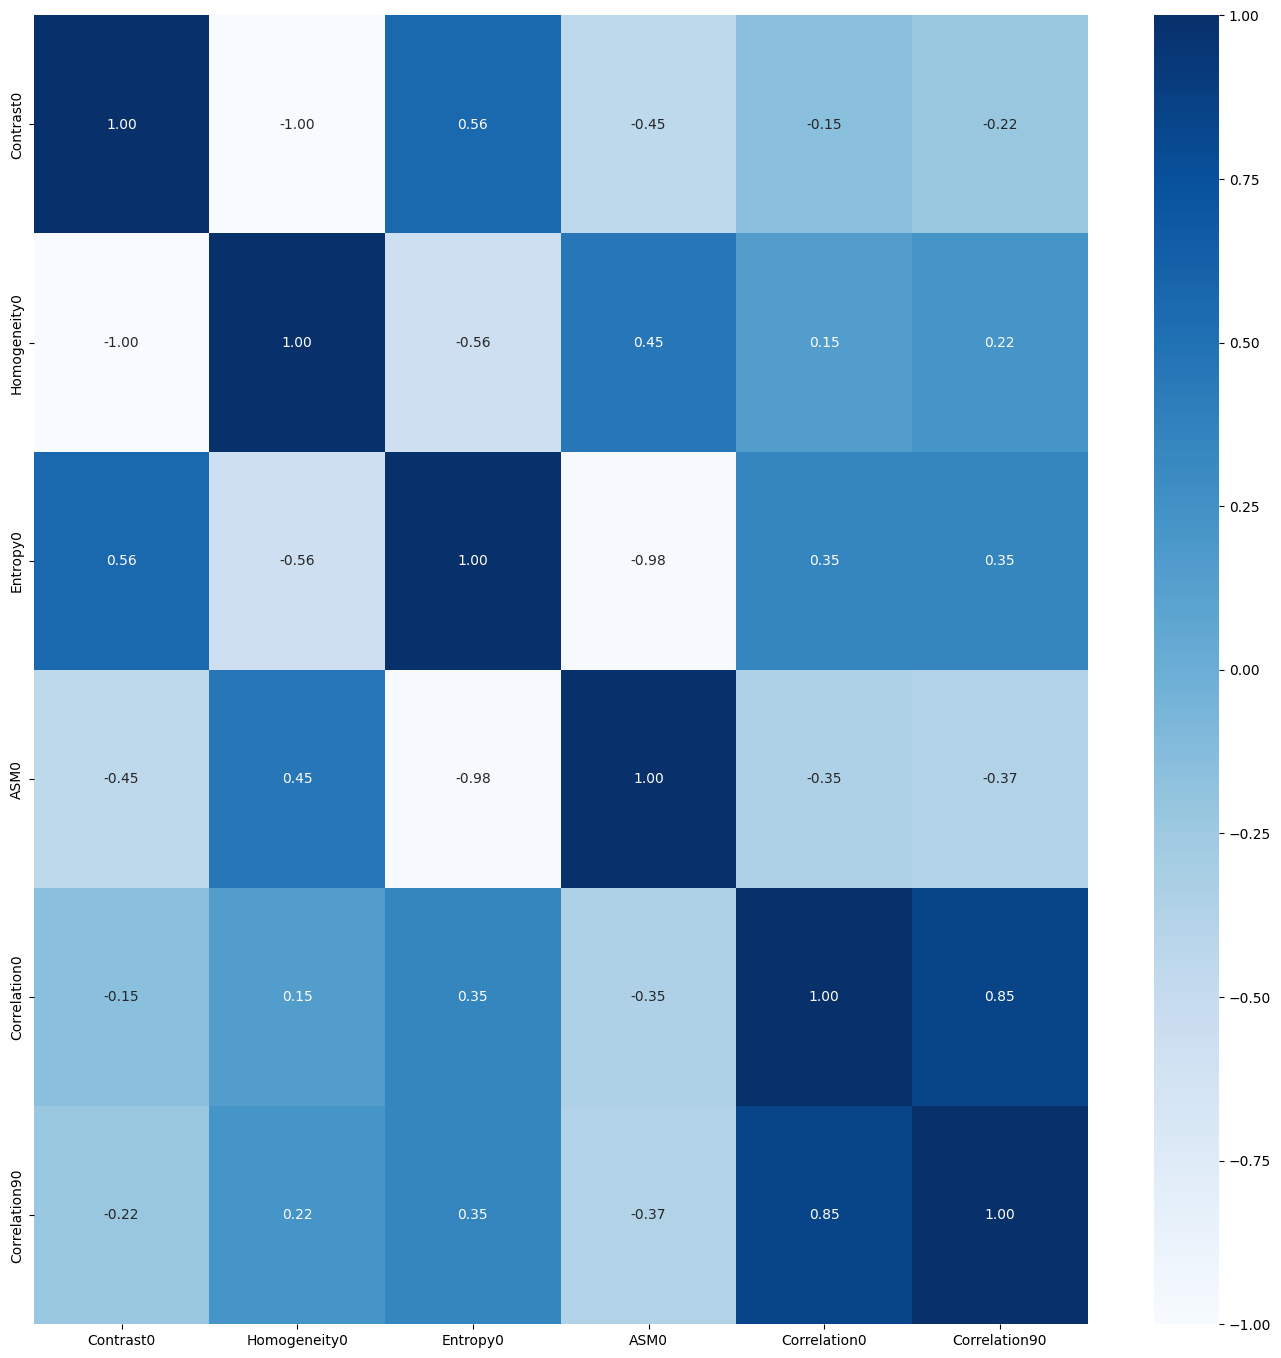

In [31]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 6)
(40, 6)


In [33]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [34]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)


In [35]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.99      0.99      0.99        79
Morchella_esculenta       0.99      0.99      0.99        81

           accuracy                           0.99       160
          macro avg       0.99      0.99      0.99       160
       weighted avg       0.99      0.99      0.99       160

[[78  1]
 [ 1 80]]
Accuracy: 0.9875

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.86      0.90      0.88        21
Morchella_esculenta       0.89      0.84      0.86        19

           accuracy                           0.88        40
          macro avg       0.88      0.87      0.87        40
       weighted avg       0.88      0.88      0.87        40

[[19  2]
 [ 3 16]]
Accuracy: 0.875


In [36]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.79      0.86      0.82        79
Morchella_esculenta       0.85      0.78      0.81        81

           accuracy                           0.82       160
          macro avg       0.82      0.82      0.82       160
       weighted avg       0.82      0.82      0.82       160

[[68 11]
 [18 63]]
Accuracy: 0.81875

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.83      0.90      0.86        21
Morchella_esculenta       0.88      0.79      0.83        19

           accuracy                           0.85        40
          macro avg       0.85      0.85      0.85        40
       weighted avg       0.85      0.85      0.85        40

[[19  2]
 [ 4 15]]
Accuracy: 0.85


In [37]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.78      0.87      0.82        79
Morchella_esculenta       0.86      0.75      0.80        81

           accuracy                           0.81       160
          macro avg       0.82      0.81      0.81       160
       weighted avg       0.82      0.81      0.81       160

[[69 10]
 [20 61]]
Accuracy: 0.8125

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.74      0.95      0.83        21
Morchella_esculenta       0.92      0.63      0.75        19

           accuracy                           0.80        40
          macro avg       0.83      0.79      0.79        40
       weighted avg       0.83      0.80      0.79        40

[[20  1]
 [ 7 12]]
Accuracy: 0.8


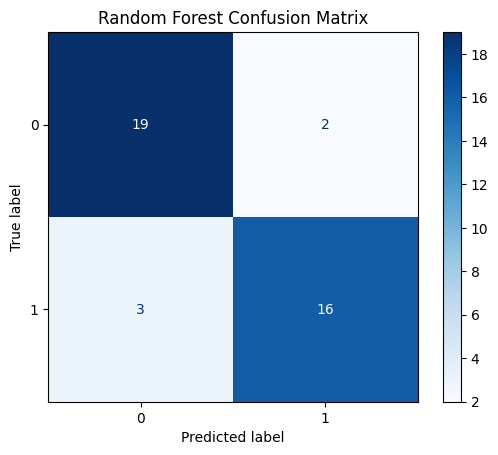

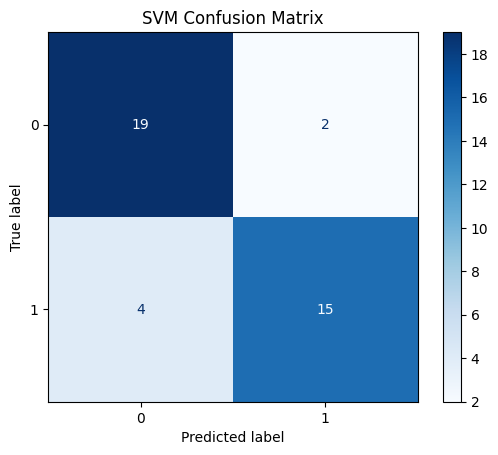

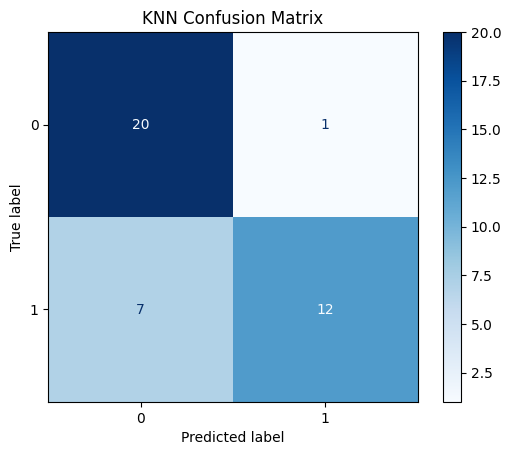

In [38]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")